# Natural Language Processing on Hindi Bible text + Sentiment Analysis and Classification

## Introduction
Analysis of Hindi Bible text of HHBD version from Bible Society of India (BSI) with NLP techniques. To perform sentiment analysis on all of the Bible books while also bringing to the surface some interesting findings based on facts such as which is the most significant verse based on the frequency of common words, who wrote most of the New Testament, etc.

## Preprocessing of Data
The data was parsed into a **CSV** format. Most of the details like Book no., Chapter No. etc. were extracted from Verseid field in the file and some details like "Book names in Hindi" and "Authors' names" were added from external sources.

The original [datasets](https://www.kaggle.com/kapilverma/hindi-bible?select=HSWN_WN.txt) can be found here.

In [374]:
import nltk
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [375]:
# library imports
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# printing list of files available to us
from os import walk as osWalk
from os.path import join as pathJoin 

datasetPath = {}
for dirname, _, filenames in osWalk('./dataset'):
    for filename in filenames:
        datasetPath[filename[:-4]] = pathJoin(dirname, filename)
        print(datasetPath[filename[:-4]])

./dataset/hindi-bible/bible books.txt
./dataset/hindi-bible/word list.csv
./dataset/hindi-bible/nirmala.ttf
./dataset/hindi-bible/stopwords.txt
./dataset/hindi-bible/sentiment word net.txt
./dataset/hindi-bible/bible with authors.csv
./dataset/hindi-bible/full text bible.txt


We will use all of the above files in our analysis. Starting with our main file `Hindi_bible_with_authors.csv`, imported as `bib`.

In [376]:
authorBible = pd.read_csv(datasetPath["bible with authors"]).drop('Unnamed: 0', axis = 1)
authorBible.head()

,Book,Chapter,Verse,Verse id,Book Name,Text,Testament Code,Authors
0,0,0,0,0-0-0,उत्पत्ति,आदि में परमेश्वर ने आकाश और पृथ्वी की सृष्टि की।,0,Moses
1,0,0,1,0-0-1,उत्पत्ति,और पृथ्वी बेडौल और सुनसान पड़ी थी; और गहरे जल ...,0,Moses
2,0,0,2,0-0-2,उत्पत्ति,"तब परमेश्वर ने कहा, उजियाला हो: तो उजियाला हो ...",0,Moses
3,0,0,3,0-0-3,उत्पत्ति,और परमेश्वर ने उजियाले को देखा कि अच्छा है; और...,0,Moses
4,0,0,4,0-0-4,उत्पत्ति,और परमेश्वर ने उजियाले को दिन और अन्धियारे को ...,0,Moses


## Exploratory Visualization

First, classifying the book titles from **bible books.txt** to the New Testament and Old Testament for classification purpose in our incoming visualizations.

In [377]:
with open(datasetPath["bible books"], mode = 'r', encoding = 'utf-8-sig') as bibleBooks:
    books = bibleBooks.read()
books = books.split("\n")
ntBooks = [i.strip('"') for i in books[39:66]]
print(ntBooks)

['मत्ती', 'मरकुस', 'लूका', 'यूहन्ना', 'प्रेरितों के काम', 'रोमियो', '1 कुरिन्थियों', '2 कुरिन्थियों', 'गलातियों', 'इफिसियों', 'फिलिप्पियों', 'कुलुस्सियों', '1 थिस्सलुनीकियों', '2 थिस्सलुनीकियों', '1 तीमुथियुस', '2 तीमुथियुस', 'तीतुस', 'फिलेमोन', 'इब्रानियों', 'याकूब', '1 पतरस', '2 पतरस', '1 यूहन्ना', '2 यूहन्ना', '3 यूहन्ना', 'यहूदा', 'प्रकाशित वाक्य']


## Exploring the length of each book
 Calculating percentage portions (% occurrences) of each book in the bible and saving it in a Pandas DataFrame (`df`).
> * While our Hindi text cannot represent the actual length of each book, the reason it being a translated text, so we would stick to the no. of verses in each book for comparison. 

In [378]:
df = pd.DataFrame(100 * authorBible.groupby("Book Name").size() / len(authorBible), columns = ["% occurrences"])
df["Testament"] = df.index.to_series().map(lambda x: 1 if x in ntBooks else 0)
df = df.sort_values("% occurrences", ascending = False)
df.head()

,% occurrences,Testament
Book Name,,
भजन संहिता,7.907844,0
उत्पत्ति,4.925934,0
यिर्मयाह,4.382893,0
यशायाह,4.151538,0
गिनती,4.138684,0


We will be using `Nirmala.ttf` font to show Hindi text on our graphs. Although the library that we are using named `Matplotlib`, its graphs do not render Hindi text properly but they are still recognizable.

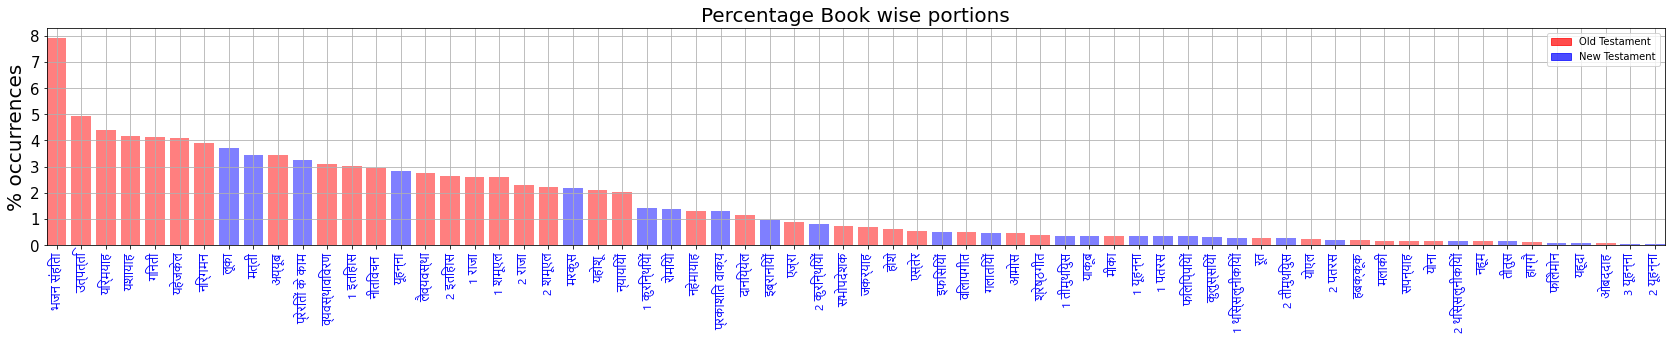

In [379]:
from matplotlib.font_manager import FontProperties
import matplotlib.patches as mpatches

hindiFont = FontProperties(fname = datasetPath["nirmala"])
redPatch = mpatches.Patch(color = 'red', alpha = 0.7, label = 'Old Testament')
bluePatch = mpatches.Patch(color = 'blue', alpha = 0.7, label = 'New Testament')

plt.grid()
plt.bar(
    df.index, 
    df["% occurrences"], 
    align = 'center', 
    alpha = 0.5, 
    color = df['Testament'].apply(lambda x: ['red', 'blue'][x])
)

plt.xticks(
    df.index, 
    color = "b", 
    fontproperties = hindiFont, 
    rotation = 90, 
    fontsize = 12
)
plt.yticks(fontsize = 15)
plt.ylabel('% occurrences', fontsize = 20)
plt.title('Percentage Book wise portions', fontsize = 20)
plt.legend(handles = [redPatch, bluePatch])
plt.gca().margins(x = 0)
plt.gcf().canvas.draw()

tickLabels = plt.gca().get_xticklabels()
maxSize = max([tick.get_window_extent().width for tick in tickLabels])
inchMargin = 0.2

margin = inchMargin / plt.gcf().get_size_inches()[0]
plt.gcf().subplots_adjust(left = margin, right = 1.0 - margin)
plt.gcf().set_size_inches(
     maxSize / plt.gcf().dpi * 100 + 2 * inchMargin, 
     plt.gcf().get_size_inches()[1]
)

As it is evident with the color-coding that the majority of the Bible is occupied by Old Testament Books. We can see that Psalms (भजन संहिता) book is the largest book in the Bible while the 2nd Epistle from John (2 यूहन्ना) is the smallest of all the books in the Bible.<br>
> *Note: This calculation is based upon the number of verses of each book, if we go by counting each word then 3rd Epistle of John (3 यूहन्ना) is the smallest book of the Bible.*

## Exploring Traditional Authorship
Authorship details are borrowed from this [article](https://overviewbible.com/authors-who-wrote-bible/). <br>As discussed above this is also based on the no. of verses. We will calculate percentage portions of each author into a dataframe using *.groupby()* function.

In [380]:
df = pd.DataFrame(100 * authorBible.groupby("Authors").size() / len(authorBible), columns = ["% occurrences"])
df = df.sort_values("% occurrences", ascending = False)
df.head()

,% occurrences
Authors,
unknown,21.969088
Moses,18.858649
Luke,6.934224
Ezra,6.567912
Paul,6.532566


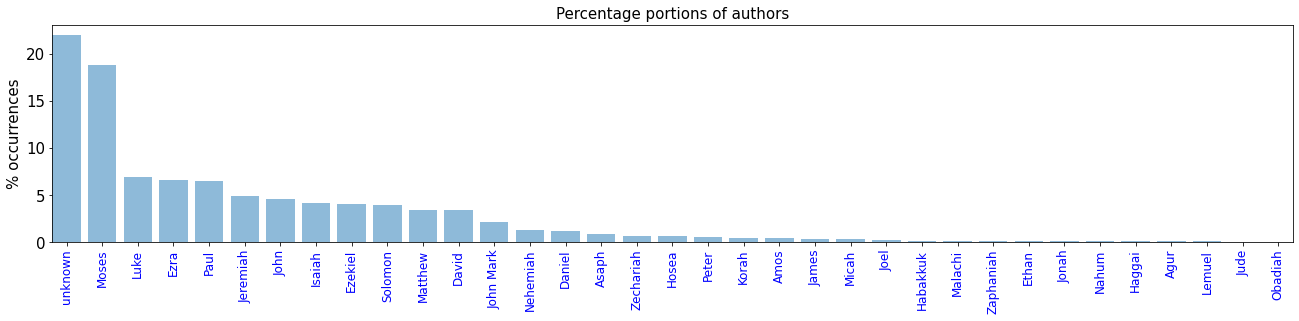

In [381]:
plt.bar(df.index, df["% occurrences"], align = 'center', alpha = 0.5)
plt.xticks(df.index, color = "b", rotation = 90, fontsize = 12)
plt.yticks(fontsize = 15)
plt.ylabel('% occurrences', fontsize = 15)
plt.title('Percentage portions of authors', fontsize = 15)
plt.gca().margins(x = 0)
plt.gcf().canvas.draw()

tickLabels = plt.gca().get_xticklabels()
maxSize = max([tick.get_window_extent().width for tick in tickLabels])
inchMargin = 0.2

margin = inchMargin / plt.gcf().get_size_inches()[0]
plt.gcf().subplots_adjust(left = margin, right = 1.0 - margin)
plt.gcf().set_size_inches(
    maxSize / plt.gcf().dpi * 100 + 2 * inchMargin, 
    plt.gcf().get_size_inches()[1]
)

Moses tops the chart among the known traditional authors and the difference is huge (around 12%) between his contribution and the immediate next contributor Luke's (This comparisions would be least of their concern though). It's interesting to note that Paul's and Ezra's contribution is almost equal and differ just by a margin of 0.03%.<br> 
> P.S. A word of clarification: When I say contribution I mean the contribution of mere no. of verses not the contribution in doctrinal or conceptual aspects. 
#### List of books having unknown authors 
There is a total of 11 books with uncredited authors, interestingly enough, out of all of them, there is only one book (इब्रानियों, Hebrews) with unknown author from the New Testament books. 

In [382]:
set(authorBible[authorBible["Authors"] == "unknown"]["Book Name"])

{'1 राजा',
 '1 शमूएल',
 '2 राजा',
 '2 शमूएल',
 'अय्यूब',
 'इब्रानियों',
 'एस्तेर',
 'न्यायियों',
 'भजन संहिता',
 'यहोशू ',
 'रूत'}

### A Separate look on the authorship of Old Testament and New Testament books

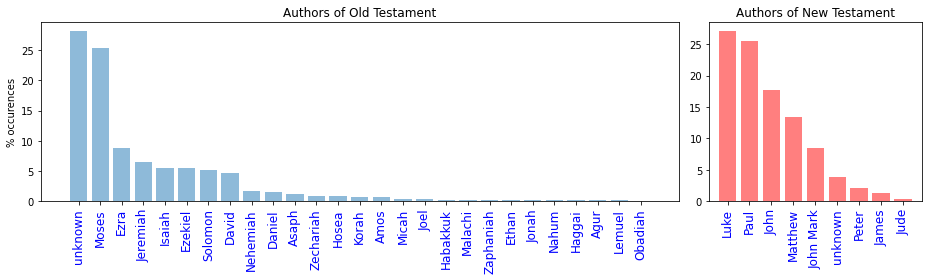

In [383]:
df_O = pd.DataFrame(
    100 * authorBible[authorBible['Testament Code'] == 0].groupby("Authors").size() / len(authorBible[authorBible['Testament Code'] == 0]), 
    columns = ["% occurrences"]
)
df_O = df_O.sort_values("% occurrences",ascending = False)
df_N = pd.DataFrame(
    100 * authorBible[authorBible['Testament Code'] == 1].groupby("Authors").size() / len(authorBible[authorBible['Testament Code'] == 1]), 
    columns = ["% occurrences"])
df_N = df_N.sort_values("% occurrences",ascending = False)

f, axes = plt.subplots(1, 2, figsize = (13,4), gridspec_kw = { 'width_ratios': [3, 1] })
axes[0].bar(df_O.index, df_O["% occurrences"], align = 'center', alpha = 0.5)
plt.sca(axes[0])
plt.xticks(df_O.index, color = "b", rotation = 90, fontsize = 12)
plt.title('Authors of Old Testament')
plt.ylabel('% occurences')

axes[1].bar(df_N.index, df_N["% occurrences"], align = 'center', alpha = 0.5, color = 'r')
plt.sca(axes[1])
plt.xticks(df_N.index, color = "b", rotation = 90, fontsize = 12)
plt.title('Authors of New Testament')
plt.tight_layout()

It can be easily seen here that relatively recent New Testament Books have lesser unknown writers (4%) as compared to the Old Testament (28%). <br>
We get an interesting finding here that to the contrary of popular belief, it is not Paul who has written most of the new testament but it is Luke. Sure, Paul has written more books but volume-wise(no. of verses), It is Luke who gave maximum contribution. [Original manuscripts](https://apologika.blogspot.com/2014/05/who-wrote-most-of-new-testament.html) also support this fact.

## Starting Text Analysis
**Stopwords** are generally the most common words in a language and for our purpose of analysis, they have to be eliminated from the text. `Hindi_StopWords.txt` is a custom made list of 270 stopwords.

In [384]:
with open(datasetPath["stopwords"], encoding = "utf-8") as stopwords:
    stopword = stopwords.read().strip("\ufeff")
stopword = stopword.split(", ")
stopword = [i.strip("'") for i in stopword]
print(stopword)

['अर्थात', 'कुछ', 'तेरी', 'साबुत', 'अपनि', 'हूं', 'काफि', 'यिह', 'जा', 'दे', 'देकर', 'रह', 'कह', 'कहा', "बात' ", 'जिन्हों', 'किर', 'कोई', 'हे', 'कोन', 'रहा', 'सब', 'सो', 'तक', 'इंहें', 'इसकि', 'अपनी', 'दबारा', 'सभि', 'होते', 'भीतर', 'निचे', 'घर', 'उन्हें', 'उन्ह', 'मेरे', 'था', 'व', 'इसमें', 'उसी', 'बिलकुल', 'होति', 'गया', 'सकता', 'अपना', 'लिये', 'उसका', 'पर', 'दवारा', 'गए', 'है', 'कितना', 'भि', 'लिए', 'वुह ', 'ना', 'किसि', 'परन्तु', 'किन्हें', 'बहुत', 'भी', 'तुम्हारे', 'निहायत', 'उन्हीं', 'वहिं', 'हैं', 'उन्हों', "इतयादि' ,'यहाँ", 'तब', 'पूरा', 'क्योंकि', 'कौनसा', 'आप', 'हुअ', 'ऐसे', 'एस', 'कारण', 'अप', 'पहले', 'तुम', 'जेसा', 'तिस', 'लेकिन', 'कहते', 'मगर', 'करता', 'संग', 'सभी', 'जीधर', 'किंहों', 'हि', 'द्वारा', 'हुआ', 'तू', 'जिंहें', 'उसने', 'पास', 'वहां', 'वह', 'किंहें', 'इंहों', 'मुझ', 'कुल', 'तिंहों', 'का', 'मेरी', 'तेरे', 'उनके', 'क्या', 'जहाँ', 'काफ़ी', 'वर्ग', 'वरग', 'बही', 'ये', 'जिस', 'इसि', 'हुई', 'साम्हने', 'नहिं', 'जैसे', 'वहीं', 'दिया', 'अभी', 'यहि', 'वग़ैरह', 'उनकि', 'न', '

## WordCloud

Using **full text bible.txt** which is a compilation of whole Hindi text of the Bible to make the WordCloud.  

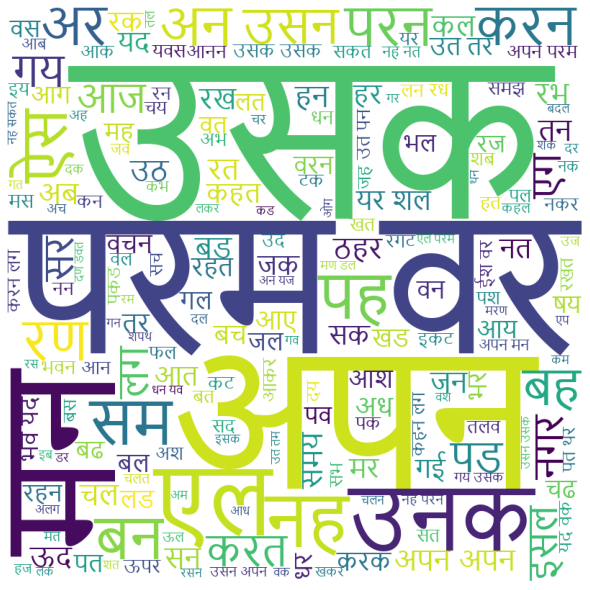

In [385]:
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize as tokenizeWord

with open(datasetPath["full text bible"], mode='r', encoding='utf-8-sig') as fullTextBible:
    text = fullTextBible.read()
%matplotlib inline

stopwords = set(stopword)
wordcloud = WordCloud(
    font_path = datasetPath["nirmala"], 
    width = 800, 
    height = 800, 
    background_color = 'white', 
    stopwords = stopwords, 
    min_font_size = 10
).generate(text) 

# plot the WordCloud image 
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis('off') 
plt.tight_layout(pad = 0) 

plt.show()

*Though WordCloud messes up with Matras of Hindi Words and the WordCloud function doesn't do well to remove stopwords but still we can see that words like परमेश्वर,मन etc. are more prominent than others. <br>Next, we'll do stemming.*

**Stemming** is the process of reducing words to their word base or root form. E.g., in English, stem word for playing, player, played etc. will be "play". This below functionality to generating Hindi stem words has been taken from [here](https://github.com/taranjeet/hindi-tokenizer/blob/master/HindiTokenizer.py). We'll use stemming to accurately arrive on most frequent words in Hindi Bible so that our program won't count words like लोग and लोगों as two different words.

In [386]:
class StemWords:
  suffixCollection = {
    2: [u"कर",u"ाओ",u"िए",u"ाई",u"ाए",u"नी",u"ना",u"ते",u"ती",u"ाँ",u"ां",u"ों",u"ें"],
    3: [u"ाकर",u"ाइए",u"ाईं",u"ाया",u"ेगी",u"ेगा",u"ोगी",u"ोगे",u"ाने",u"ाना",u"ाते",u"ाती",u"ाता",u"तीं",u"ाओं",u"ाएं",u"ुओं",u"ुएं",u"ुआं"],    
    4: [u"ाएगी",u"ाएगा",u"ाओगी",u"ाओगे",u"एंगी",u"ेंगी",u"एंगे",u"ेंगे",u"ूंगी",u"ूंगा",u"ातीं",u"नाओं",u"नाएं",u"ताओं",u"ताएं",u"ियाँ",u"ियों",u"ियां"],
    5: [u"ाएंगी",u"ाएंगे",u"ाऊंगी",u"ाऊंगा",u"ाइयाँ",u"ाइयों",u"ाइयां"],
  }

  @classmethod
  def generate(cls, word):
    for suffixLen, suffixes in cls.suffixCollection.items():
        if len(word) > suffixLen + 1:
            for suffix in suffixes:
                if word.endswith(suffix):
                    return word[:-suffixLen]
    return word


### Most frequent words in Hindi Bible

{'यहोवा': 6260, 'परमेश्वर': 3788, 'लोग': 3262, 'पुत्र': 2413, 'देश': 2401, 'राजा': 2383, 'दिन': 2308, 'बात': 2145, 'हाथ': 1774, 'मनुष्य': 1691, 'नाम': 1649, 'काम': 1644, 'इस्राएल': 1322, 'नगर': 1320, 'मन': 1134, 'सुन': 1093, 'समय': 1070, 'वचन': 1062, 'प्रभु': 1047, 'देख': 1040}


([<matplotlib.axis.YTick at 0x7f741334f550>,
 [Text(0, 0, 'यहोवा'),
  Text(0, 0, 'परमेश्वर'),
  Text(0, 0, 'लोग'),
  Text(0, 0, 'पुत्र'),
  Text(0, 0, 'देश'),
  Text(0, 0, 'राजा'),
  Text(0, 0, 'दिन'),
  Text(0, 0, 'बात'),
  Text(0, 0, 'हाथ'),
  Text(0, 0, 'मनुष्य'),
  Text(0, 0, 'नाम'),
  Text(0, 0, 'काम'),
  Text(0, 0, 'इस्राएल'),
  Text(0, 0, 'नगर'),
  Text(0, 0, 'मन'),
  Text(0, 0, 'सुन'),
  Text(0, 0, 'समय'),
  Text(0, 0, 'वचन'),
  Text(0, 0, 'प्रभु'),
  Text(0, 0, 'देख')])

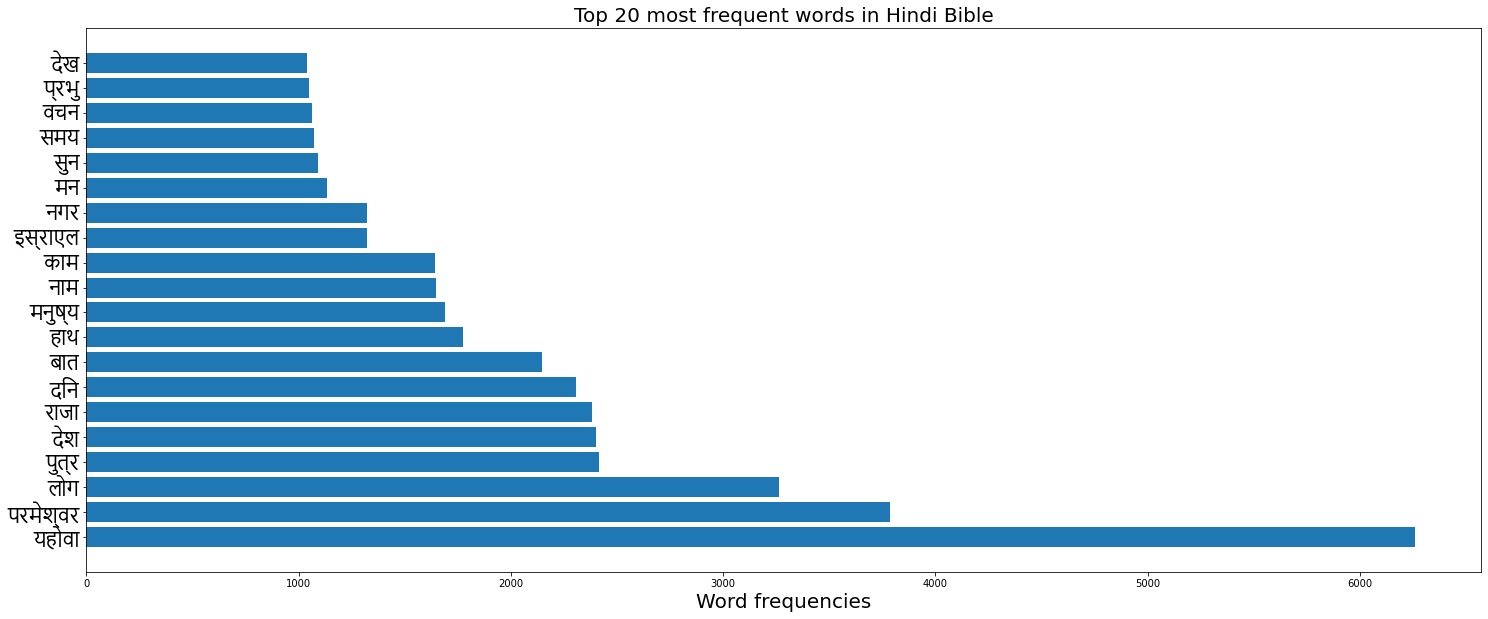

In [387]:
from collections import Counter as collectionCounter

wordcount = {}
# To eliminate duplicates, we will split by punctuation, and use case demiliters.
for word in text.split():
    word = word.replace(".", "")
    word = word.replace(",", "")
    word = word.replace(":", "")
    word = word.replace(";", "")
    word = word.replace('"', "")
    word = word.replace("!", "")
    word = StemWords.generate(word)

    if word not in stopwords:
        if word not in wordcount:
            wordcount[word] = 1
        else:
            wordcount[word] += 1

# most common word
wordFreq = {}
for word, count in collectionCounter(wordcount).most_common(20):
    wordFreq[word] = count
print(wordFreq)

freqDf = pd.DataFrame(list(wordFreq.items()), index = range(20), columns = ['word', 'freq']) 
fig, ax = plt.subplots(figsize = (25,10))
ax.barh(freqDf['word'], freqDf['freq'], align = 'center')
ax.set_xlabel('Word frequencies', fontsize = 20)
ax.set_title('Top 20 most frequent words in Hindi Bible', fontsize = 20)
plt.yticks(range(len(wordFreq.keys())), list(wordFreq.keys()), fontproperties = hindiFont, fontsize = 20)

## Abstract Extraction by significance score
Let’s further prepare the input text from our corpus for further processing, by removing punctuation and stopwords (custom made list). In this section, we'll try to find most significant verses in Hindi Bible.<br>
#### A simple word-frequency finder
We have to find the frequency of each word also to derive significance. While we are at it, It will be useful to have a function which can find the frequency of any word we search for. Our function `freq_finder` does the same, there are examples given below for words: प्रेम (Love) and डर (Fear).
> This is specific to HHBD version only.

In [388]:
from string import punctuation
from nltk.probability import FreqDist

tokens = tokenizeWord(text)
customStopwords = set(list(stopwords) + list(punctuation + '।' + '॥'))
filteredStopwords = [word for word in tokens if word not in customStopwords]

#removing numeric digits from list of words
filteredStopwords = [i for i in filteredStopwords if not i.isdigit()]
freqDist = FreqDist(filteredStopwords)
  
print("In HHBD Hindi Bible")
print(f"प्रेम appears for {freqDist['प्रेम']} times")
print(f"डर appears for {freqDist['डर']} times")

In HHBD Hindi Bible
प्रेम appears for 350 times
डर appears for 199 times


For you curious ones out there, here's a dictionary of words with their frequencies that might interest you.

In [389]:
checkWords = ['यीशु', 'मसीह', 'उद्धारकर्ता', 'उद्धार', 'क्रूस' ]
checkWordFreq = {}
for checkWord in checkWords:
    checkWordFreq[checkWord] = freqDist[checkWord]

print(checkWordFreq)

{'यीशु': 797, 'मसीह': 532, 'उद्धारकर्ता': 41, 'उद्धार': 276, 'क्रूस': 77}


In [390]:
freqDist.pop('राजा', None)
freqDist

FreqDist({'परमेश्वर': 3813,
          'आकाश': 353,
          'पृथ्वी': 759,
          'सृष्टि': 38,
          'की।और': 47,
          'बेडौल': 3,
          'सुनसान': 30,
          'पड़ी': 112,
          'गहरे': 2,
          'जल': 476,
          'ऊपर': 549,
          'अन्धियारा': 18,
          'तथा': 19,
          'आत्मा': 492,
          'मण्डलाता': 2,
          'था।तब': 92,
          'उजियाला': 49,
          'गया।और': 188,
          'उजियाले': 32,
          'देखा': 592,
          'अच्छा': 206,
          'अन्धियारे': 45,
          'अलग': 265,
          'किया।और': 120,
          'दिन': 1967,
          'रात': 325,
          'कहा।': 5,
          'सांझ': 114,
          'भोर': 132,
          'हुआ।': 34,
          'प्रकार': 564,
          'पहिला': 40,
          'गया॥फिर': 18,
          'बीच': 820,
          'अन्तर': 24,
          'भाग': 683,
          'जाए।तब': 25,
          'करके': 826,
          'वैसा': 299,
          'दूसरा': 127,
          'स्थान': 830,
          'इकट्ठा': 151,
          '

`freq` dictionary contains frequency of each word, we are taking frequency as a score of a particular word's importance. 
> *I have intentionally removed word 'राजा' so that our algorithm won't give significance to verses containing lineages of various Kings*

In [391]:
sents = []
for i in text.split("॥"):
    sents.append(i.split('।'))
sents = [item for sublist in sents for item in sublist]

In the above code, We split our full bible text by *Puran Virams* & *Ardh Virams* i.e. '॥' & '।' and stored the resulted sentences in a flattened list `sents`. Next, we're ranking these sentences based on significance scores of their constituting words, in dictionary `ranking`.

In [392]:
from collections import defaultdict

ranking = defaultdict(int)
for i, sent in enumerate(sents):
    for token in tokenizeWord(sent):
        if token in freqDist:
            ranking[i] += freqDist[token]        

We'll use these ranking to arrive at significant sentences as per the ranking calculated above.

In [393]:
from heapq import nlargest

sentsIdx = nlargest(1, ranking, key = ranking.get)
summary = [sents[j] for j in sorted(sentsIdx)]
summary

['तब रूबेनियों, गादियों, और मनश्शे के आधे गोत्रियों ने इस्राएल के हजारों के मुख्य पुरूषों को यह उत्तर दिया,कि यहोवा जो ईश्वरों का परमेश्वर है, ईश्वरों का परमेश्वर यहोवा इस को जानता है, और इस्राएली भी इसे जान लेंगे, कि यदि यहोवा से फिरके वा उसका विश्वासघात करके हम ने यह काम किया हो, तो तू आज हम को जीवित न छोड़,यदि आज के दिन हम ने वेदी को इसलिये बनाया हो कि यहोवा के पीछे चलना छोड़ दें, वा इसलिये कि उस पर होमबलि, अन्नबलि, वा मेलबलि चढ़ाएं, तो यहोवा आप इसका हिसाब ले;परन्तु हम ने इसी विचार और मनसा से यह किया है कि कहीं भविष्य में तुम्हारी सन्तान हमारी सन्तान से यह न कहने लगे, कि तुम को इस्राएल के परमेश्वर यहोवा से क्या काम?क्योंकि, हे रूबेनियों, हे गादियों, यहोवा ने जो हमारे और तुम्हारे बीच में यरदन को हद्द ठहरा दिया है, इसलिये यहोवा में तुम्हारा कोई भाग नहीं है']

It gives Joshua (यहोशू) chapter 22, verses 21-27 as the most significant verses in the Hindi Bible.

### Hierarchical Clustering
Here, I have done hierarchical Clustering on the first 10 sentences of Bible i.e Genesis (उत्पत्ति) 1:1-10. Sentences (denoted by a title words 'जल', 'ऊपर', 'आकाश' etc.) are clustered based on their cosine distances and their hierarchy is found out by Ward's method which merges cluster based on their cosine distances. <sub>(Cosine distance = 1- cosine similarity)</sub> <br><br>Cosine distance  is opposite to cosine similarity which calculates similarity between two vectors based on the cosine ratio of the angle made between them two. See, if you can make sense of below dendrogram.

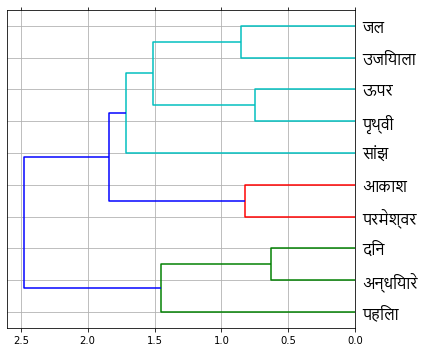

In [394]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity as cosSimilarity
from scipy.cluster.hierarchy import ward, dendrogram

#define vectorizer parameters
tfidfVectorizer = TfidfVectorizer(
    max_df = 0.8, 
    max_features = 200000,
    min_df = 0.2, 
    stop_words = stopwords,
    use_idf = True, 
    tokenizer = word_tokenize, 
    ngram_range = (1,3)
)
tfidfMatrix = tfidfVectorizer.fit_transform(sents[:10])

dist = 1 - cosSimilarity(tfidfMatrix)
linkageMatrix = ward(dist)
titles = ['परमेश्वर', 'पृथ्वी', 'उजियाला', 'अन्धियारे', 'दिन', 'सांझ', 'पहिला', 'जल', 'ऊपर', 'आकाश']
fig, ax = plt.subplots(figsize=(6, 5)) # set size

ax = dendrogram(linkageMatrix, orientation = "left", labels = titles);

plt.tick_params(
    axis = 'x',          # changes apply to the x-axis
    which = 'both',      # both major and minor ticks are affected
    bottom = 'off',      # ticks along the bottom edge are off
    top = 'off',         # ticks along the top edge are off
    labelbottom = 'off'
)
plt.grid()
plt.yticks(fontproperties = hindiFont, fontsize = 15)
plt.tight_layout() #show plot with tight layout
plt.show()

## Resource-based Sentiment Analysis

### Hindi Word Net

Hindi WordNet (developed by IIT Bombay) is a similar resource like the WordNet in English, which captures lexical and semantic relations between Hindi words. Using only **sentiment word net** as we are only concerned with the Sentiment Analysis of it. It contains sentiment polarity of Hindi words while clubbing their synonyms as well.
<br/>
Reading text file **sentiment word net.txt** containing Hindi Sentiment WordNet into a Pandas Dataframe data.

In [395]:
data = pd.read_csv(
    datasetPath["sentiment word net"], 
    delimiter = " ", 
    names = ["POS TAG", "HWN ID", "+ve score", "-ve score", "Related words"], 
    header = None
)
data.head()

,POS TAG,HWN ID,+ve score,-ve score,Related words
0,a,10363,0.000,0.000,अनौपचारिक
1,a,2627,0.000,0.750,मृत
2,a,11476,0.125,0.000,परवर्ती
3,a,28106,0.250,0.375,"अच्छा,बढ़िया"
4,a,1156,0.875,0.000,"सौभाग्यशाली,खुशकिस्मत,खुशनसीब,तक़दीर_वाला,नसीब..."


In [396]:
wordsDict = {}
for i in data.index:
    words = data["Related words"][i].split(",")
    for word in words:
        wordsDict[word] = (data["POS TAG"][i], data["+ve score"][i], data["-ve score"][i])

print(f"The size of the Hindi Sentiment Word Net : {len(wordsDict)} words")

The size of the Hindi Sentiment Word Net : 9805 words


Clearly, this small amount of words won't be enough.
### Using Machine Translation to improve our sentiment resource
`hindi word list.csv` is just a list of Hindi words and their Hindi Translations, translated using Google's translation API. We're using *TextBlob* to get sentiment polarity of these translated Hindi words. This way we have more Hindi words to check sentiment polarity from.

In [397]:
from textblob import TextBlob

posData = pd.read_csv(datasetPath["word list"], header = None, names = ["Hindi", "English"])
polarityList = []
for i in posData["English"].tolist():
    blob = TextBlob(i)
    polarityList.append(blob.sentiment.polarity) 
posData["polarity"] = polarityList
posData.head()

,Hindi,English,polarity
0,अंमुक्त,Free,0.4
1,अखंड,Unbroken,0.0
2,अखण्ड,Akhand,0.0
3,अग्रगण्य,Leading,0.0
4,अचूकता,Infallibility,0.0


In [398]:
sentimentResource = set(list(wordsDict.keys()) + list(posData['Hindi']))
print(f"We have {len(set(filteredStopwords))} unique words without stopwords in Hindi Bible")
print(f"And we have total {len(sentimentResource)} unique words in our sentiment resources")

remaining = [i for i in set(filteredStopwords) if i not in sentimentResource]
print(f"The remaining words i.e. total unique words - (Sentiment Resource): {len(set(remaining))} words")

We have 29019 unique words without stopwords in Hindi Bible
And we have total 10703 unique words in our sentiment resources
The remaining words i.e. total unique words - (Sentiment Resource): 27592 words


For general purpose Hindi WordNet is sufficient to use for sentiment analysis tasks (I have shown an example below with a sample statement) but Bible text is so rich in its content that Hindi WordNet is not enough as we can see in the above result that no. of unique words used in Bible are huge compared to our resources.<br><br>
In `Code`, `sentiment` function determines sentiment of a given text. it returns 1 if the text is a positive sentence and 0 if it is a negative sentence along with their respective polarities.

In [399]:
def sentiment(text):
    words = tokenizeWord(text)
    words = [i for i in words if i not in customStopWords]
    posPolarity = 0
    negPolarity = 0
    #adverbs, nouns, adjective, verb are only used
    allowedWords = ['a','v','r','n']
    for word in words:
        if word in wordsDict:
            #if word in dictionary, it picks up the positive and negative score of the word
            posTag, pos, neg = wordsDict[word]
            if posTag in allowedWords:
                if pos > neg:
                    posPolarity += pos
                elif neg > pos:
                    negPolarity += neg
        elif word in posData["Hindi"]:
            polarity = posData[posData["Hindi"] == word]["polarity"]
            if polarity >= 0:
                posPolarity += polarity
            elif polarity < 0:
                negPolarity += polarity

    #calculating the no. of positive and negative words in total in a review to give class labels
    if posPolarity > negPolarity:
        return 1, posPolarity
    else:
        return 0, -negPolarity

print("For statment: मैं इस उत्पाद से बहुत खुश हूँ")
print(f"Overall sentiment and it's polarity is {sentiment('मैं इस उत्पाद से बहुत खुश हूँ')}")

For statment: मैं इस उत्पाद से बहुत खुश हूँ
Overall sentiment and it's polarity is (1, 0.5)


### Text split on books
Making a list of 66 strings having separate full texts belonging to each book. 

In [400]:
fullList = []
bookFlag = range(66)
for j in bookFlag:
    chapterTxt = []
    for i in authorBible.index:
        if authorBible["Book"][i] == bookFlag[j]:
            chapterTxt.append(authorBible["Text"][i])
    fullList.append("".join(chapterTxt))

print(f"Length of the resulting list: {len(fullList)}")   

Length of the resulting list: 66


In [401]:
Books = [i.strip('"') for i in books[0:66]]
print(Books)

['उत्पत्ति', 'निर्गमन', 'लैव्यवस्था', 'गिनती', 'व्यवस्थाविवरण', 'यहोशू ', 'न्यायियों', 'रूत', '1 शमूएल', '2 शमूएल', '1 राजा', '2 राजा', '1 इतिहास', '2 इतिहास', 'एज्रा', 'नहेमायाह', 'एस्तेर', 'अय्यूब', 'भजन संहिता', 'नीतिवचन ', 'सभोपदेशक', 'श्रेष्ठगीत', 'यशायाह', 'यिर्मयाह', 'विलापगीत', 'यहेजकेल', 'दानिय्येल', 'होशे', 'योएल', 'आमोस', 'ओबद्दाह', 'योना', 'मीका', 'नहूम', 'हबक्कूक', 'सपन्याह', 'हाग्गै', 'जकर्याह', 'मलाकी', 'मत्ती', 'मरकुस', 'लूका', 'यूहन्ना', 'प्रेरितों के काम', 'रोमियो', '1 कुरिन्थियों', '2 कुरिन्थियों', 'गलातियों', 'इफिसियों', 'फिलिप्पियों', 'कुलुस्सियों', '1 थिस्सलुनीकियों', '2 थिस्सलुनीकियों', '1 तीमुथियुस', '2 तीमुथियुस', 'तीतुस', 'फिलेमोन', 'इब्रानियों', 'याकूब', '1 पतरस', '2 पतरस', '1 यूहन्ना', '2 यूहन्ना', '3 यूहन्ना', 'यहूदा', 'प्रकाशित वाक्य']


List of books to be used in the below graph.
### Sentiment of each book
Well, there's going to be a little to no sense to this section as Bible text is very subjective and sentence carrying negative sentiments can turn out to be positive! E.g. Matthew 11:12 (*And from the days of John the Baptist until now the kingdom of heaven suffers violence, and the violent take it by force*) is a fairly negative sentence by the look of it but on the contrary, Jesus is giving here a graphic picture of the enthusiasm and excitement generated among people to enter the kingdom of God, that they are not caring about the difficulties and persecution they might have to endure along the way.<br>
Still, let's give it a try.

([<matplotlib.axis.YTick at 0x7f741469d9d0>,
 <a list of 66 Text major ticklabel objects>)

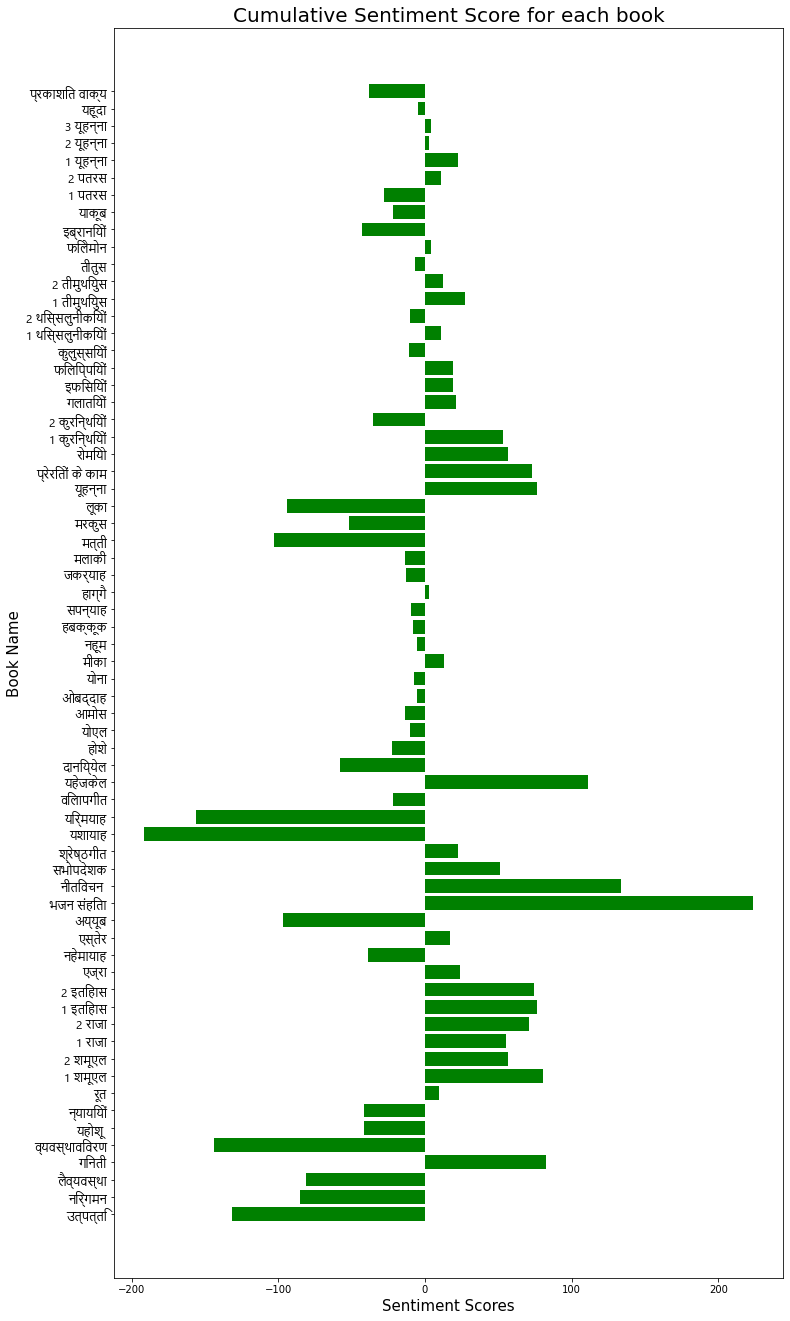

In [402]:
polarityList = []
for i in fullList:
    polarityList.append(sentiment(i)[1])
  
polarityDict = dict(zip(Books, polarityList))
polarityDf = pd.DataFrame({
    'Book': list(polarityDict.keys()),
    'Polarity': list(polarityDict.values())
})

fig, ax = plt.subplots(figsize = (12,23))
ax.barh(pol_df["Book"], pol_df["Polarity"], color = 'green');
ax.set_xlabel('Sentiment Scores', fontsize = 15)
ax.set_ylabel('Book Name', fontsize = 15)
ax.set_title('Cumulative Sentiment Score for each book', fontsize = 20)
plt.yticks(list(Polarity_dict.keys()), fontproperties = hindiFont, fontsize = 12)

As expected and discussed, this sentiment result of each book is not satisfactory as it is showing first three Gospel books also as having negative sentiment, which is certainly not the case.<br> Thanks for reading, I will be updating the notebook in the future hopefully with good sentiment results. Suggestions and feedbacks are most welcome.
## References
[1] Gabrel Preda, Kaggle notebook: https://www.kaggle.com/gpreda/explore-king-james-bible-books <br>
[2] Jeffrey Kranz, overviewbible.com: https://overviewbible.com/authors-who-wrote-bible/<br>
[3] Brandon Rose's Blog: http://brandonrose.org/clustering<br>
[4] Lohit Parmar, Github project: https://github.com/Lohit13/HindiSentimentAnalysis<br>
[5] A Framework for Sentiment Analysis in Hindi using
HSWN: https://pdfs.semanticscholar.org/cfd2/d189c5613c85077125f41c0d79d22f4d30c4.pdf